# PyTorch Portfolio Project by Marcus Strauch

This project contains an ablation study using a residual neural network architecture with and without convolutional block attention modules (CBAM) as proposed by Woo, Sanghyun, et al. (2018) [[1]](#cbam). Both models are trained on the plant disease image dataset published by Mohanty et. al. (2016) [[2]](#plantvillage), using the same training loop, loss function, optimizer and scheduler. The aim was to investigate whether the inclusion of CBAM can markedly increase the multiclassification performance of the neural network model for an unbalanced, moderately sized dataset of images.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from collections import Counter

sns.set_style('darkgrid')
sns.set_palette('Greens_d')

# This function is used before model training to enable repeatability of the ablation study
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Here, we observe that the dataset is extremely unbalanced, which makes it interesting for the intended ablation study. The most frequent class makes up  10.14% of the dataset, while the least frequent class only represents 0.28% of the data.

In [2]:
dataset = datasets.ImageFolder(root='./data/color')
labels = np.array(dataset.targets)
indices = np.arange(len(dataset))

def clean_class_name(name):
    return name.replace("___", " | ").replace("_", " ").replace(" (", "(")
cleaned_classes = [clean_class_name(c) for c in dataset.classes]
class_to_clean = {c: clean_class_name(c) for c in dataset.classes}
longest_class_name = max([len(c) for c in cleaned_classes])
cleaned_classes_same_length = [c.ljust(longest_class_name) for c in cleaned_classes]

# Number of images per class
plant_disease_counts = Counter([cleaned_classes[label] for label in labels]).most_common()
# Class weights are used to balance the loss function
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [3]:
for label, count in plant_disease_counts:
    print(f'{label.ljust(longest_class_name)}: {count / len(labels) * 100:.2f}%')

Orange | Haunglongbing(Citrus greening)          : 10.14%
Tomato | Tomato Yellow Leaf Curl Virus           : 9.86%
Soybean | healthy                                : 9.37%
Peach | Bacterial spot                           : 4.23%
Tomato | Bacterial spot                          : 3.92%
Tomato | Late blight                             : 3.52%
Squash | Powdery mildew                          : 3.38%
Tomato | Septoria leaf spot                      : 3.26%
Tomato | Spider mites Two-spotted spider mite    : 3.09%
Apple | healthy                                  : 3.03%
Tomato | healthy                                 : 2.93%
Blueberry | healthy                              : 2.77%
Pepper, bell | healthy                           : 2.72%
Tomato | Target Spot                             : 2.59%
Grape | Esca(Black Measles)                      : 2.55%
Corn(maize) | Common rust                        : 2.20%
Grape | Black rot                                : 2.17%
Corn(maize) | healthy         

<Axes: >

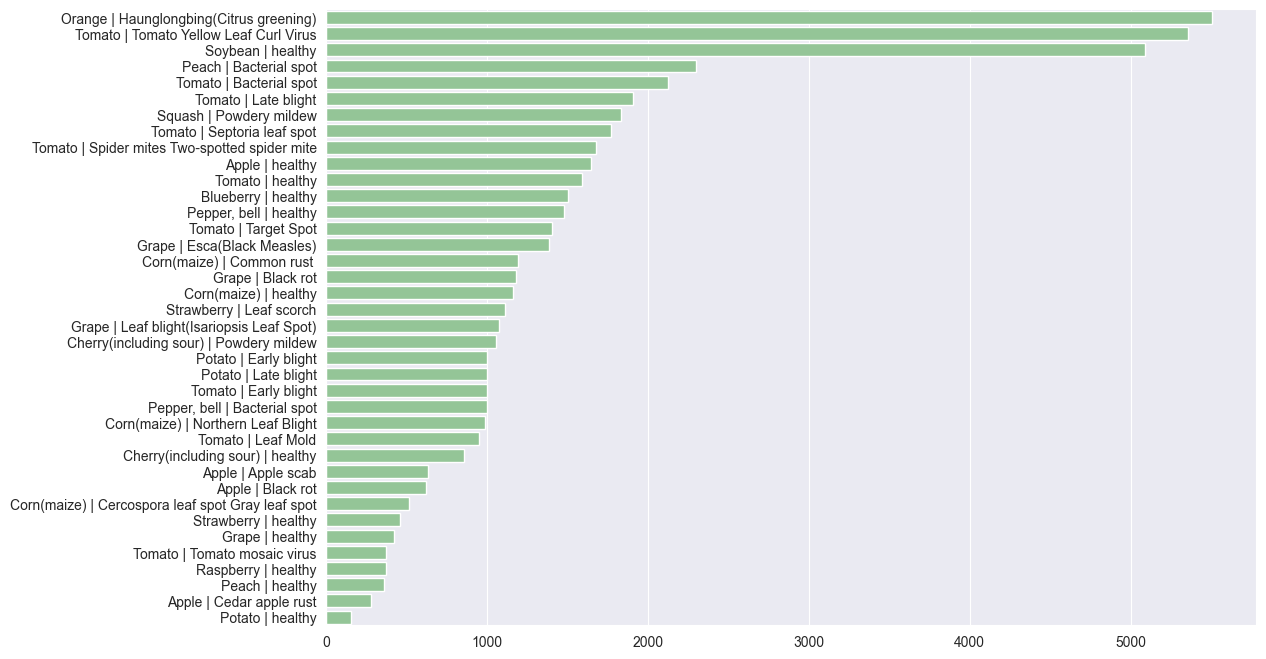

In [4]:
plt.figure(figsize=(12,8))
sns.barplot(x=[x[1] for x in plant_disease_counts], y=[x[0] for x in plant_disease_counts])

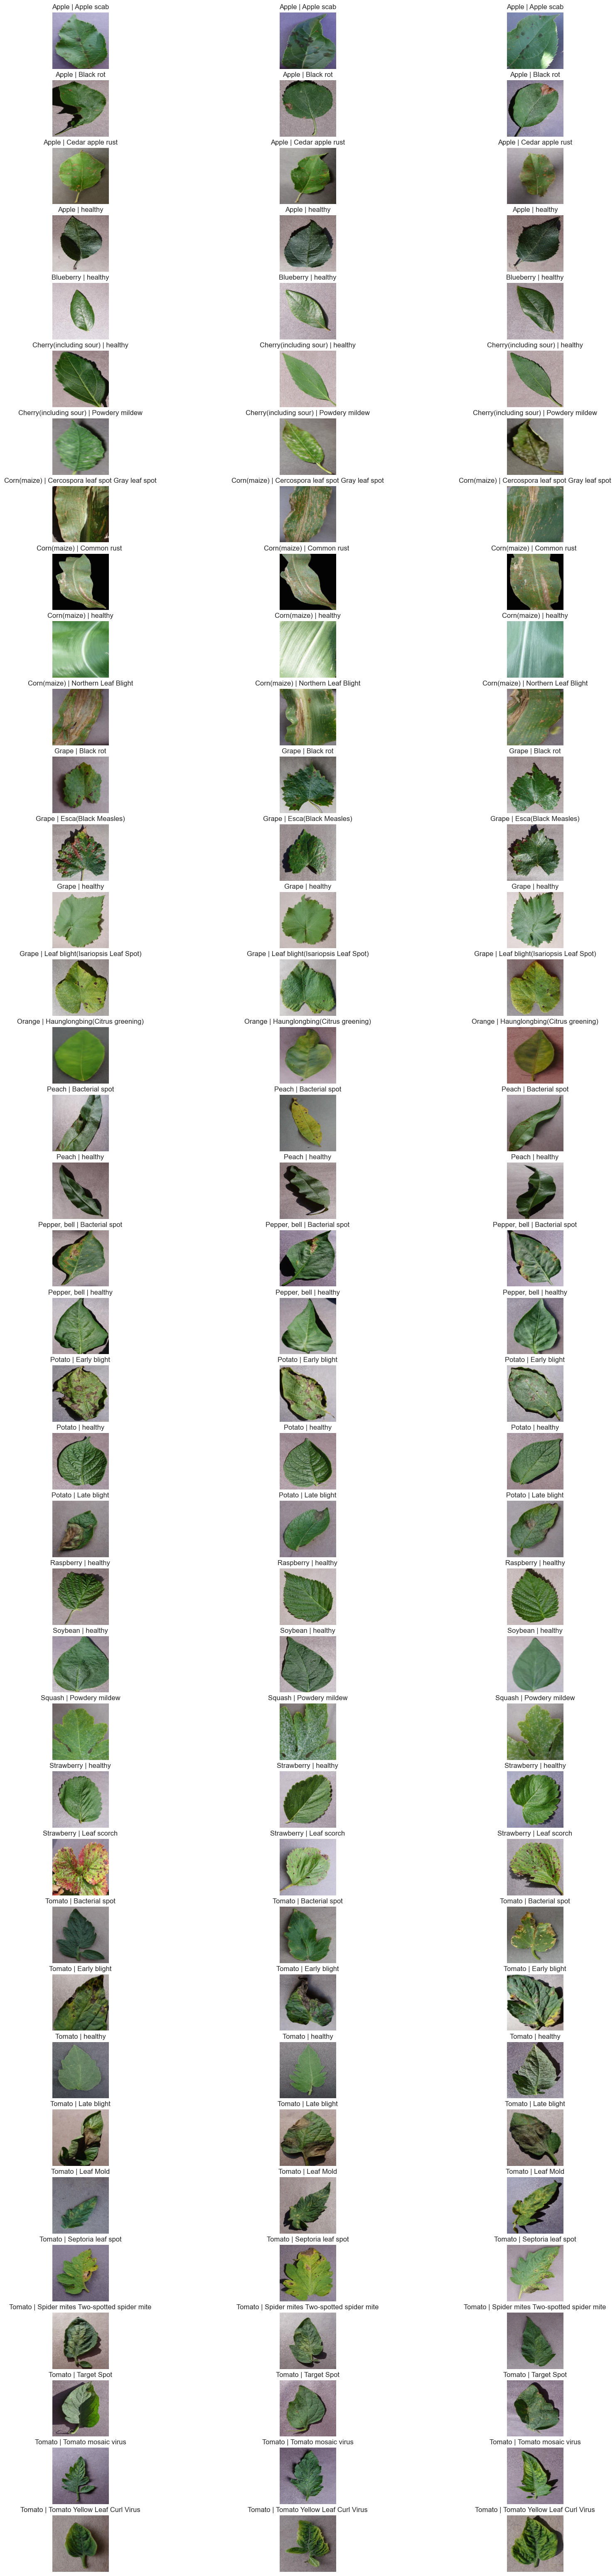

In [5]:
fig, axes = plt.subplots(38, 3, figsize=(20, 80))
for i, disease_class in enumerate(os.listdir('./data/color')):
    class_images = [img for img in os.listdir(f'./data/color/{disease_class}')][:3]
    for j, image in enumerate(class_images):
        ax = axes[i, j]
        img = Image.open(f'./data/color/{disease_class}/{image}')
        ax.imshow(img)
        ax.set_title(class_to_clean[disease_class])
        ax.axis('off')    

In [6]:
def training_transforms(image_size=224):
    return A.Compose(
        [
            # Step 1: Resize to image_size
            A.ToRGB(),
            A.Resize(image_size, image_size),
            
            # Step 2: Random geometric augmentations
            A.OneOf(
                [
                    A.HorizontalFlip(p=1.0),
                    A.VerticalFlip(p=1.0),
                    A.RandomRotate90(p=1.0),
                    A.Transpose(p=1.0),
                ],
                p=0.5,
            ),
            
            # Step 3: Random color augmentations
            A.OneOf(
                [
                    A.RandomBrightnessContrast(
                        brightness_limit=0.2, contrast_limit=0.2, p=1.0
                    ),
                    A.HueSaturationValue(
                        hue_shift_limit=20,
                        sat_shift_limit=30,
                        val_shift_limit=20,
                        p=1.0,
                    ),
                ],
                p=0.5,
            ),
            
            # Step 4: Random noise
            A.OneOf(
                [
                    A.GaussianBlur(blur_limit=3, p=1.0),
                    A.MotionBlur(blur_limit=3, p=1.0),
                    A.MedianBlur(blur_limit=3, p=1.0),
                ],
                p=0.5,
            ),
            
            # Step 5: Normalize
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )


def validation_transforms(image_size=224):
    return A.Compose(
        [
            A.Resize(image_size, image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )
    
def transform_helper(img_path):
    img = Image.open(img_path)
    return img


class Transform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image.convert("RGB"))
        return self.transform(image=image)["image"]

In [34]:
# This ensures that the train, val, and test splits contain the same proportion of images from each class
# Note that this only generates indices, not the actual datasets. The datasets are created in the next cell
train_idx, val_test_idx, y_train, y_val_test = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)
val_idx, test_idx, y_val, y_test = train_test_split(
    val_test_idx, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test
)

In [37]:
train_dataset = datasets.ImageFolder(
    root="./data/color",
    transform=Transform(training_transforms()),
    loader=transform_helper,
)
val_dataset = datasets.ImageFolder(
    root="./data/color",
    transform=Transform(validation_transforms()),
    loader=transform_helper,
)

train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(val_dataset, val_idx)
test_subset = torch.utils.data.Subset(val_dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

c:\Users\marcu\Documents\Coding\PythonProjects\.venv\Lib\site-packages\albumentations\core\transforms_interface.py:313: UserWarning: The image is already an RGB.
  target_function(ensure_contiguous_output(arg), **params),


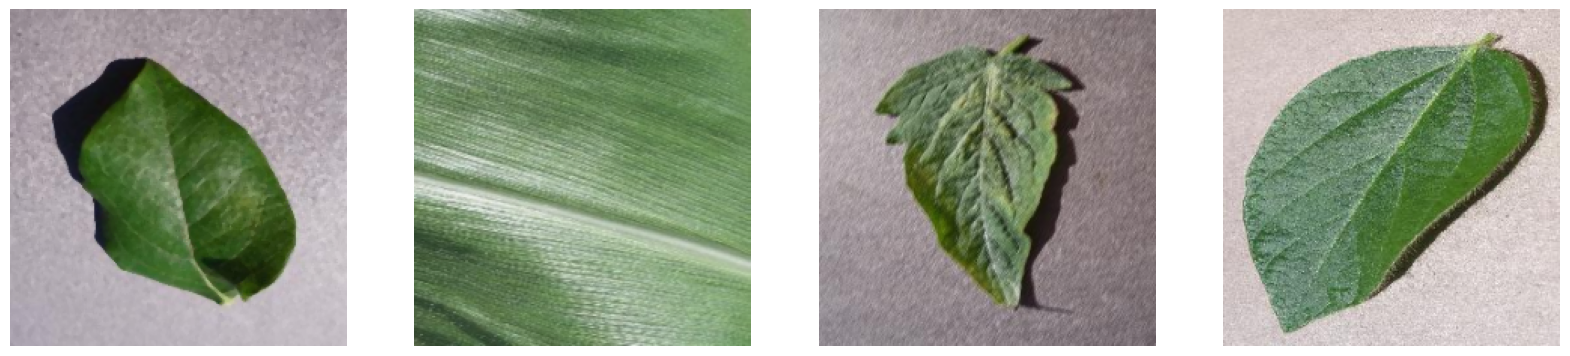

In [10]:
first_batch = next(iter(train_loader))
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(unorm(first_batch[0][i]).permute(1, 2, 0))
    ax[i].axis('off')

In [30]:
class CA(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.mlp(self.avg_pool(x))
        max_ = self.mlp(self.max_pool(x))
        return x * self.sigmoid(avg + max_)


class SA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, max_], dim=1)
        return x * self.sigmoid(self.conv(x_cat))


class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.ca = CA(channels)
        self.sa = SA()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x


class ResNetBlockCBAM(nn.Module):
    def __init__(self, in_channels, out_channels, use_cbam, stride=2):
        super().__init__()

        self.use_cbam = use_cbam

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.cbam = CBAM(out_channels) if use_cbam else nn.Identity()

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out += self.shortcut(x)
        return F.relu(out)


class PlantDiseaseMulticlassResNetOptionalCBAM(nn.Module):
    def __init__(self, num_classes, use_cbam):
        super(PlantDiseaseMulticlassResNetOptionalCBAM, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.layer1 = ResNetBlockCBAM(32, 64, stride=1, use_cbam=False)
        self.layer2 = ResNetBlockCBAM(64, 128, use_cbam=use_cbam)
        self.layer3 = ResNetBlockCBAM(128, 256, use_cbam=use_cbam)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

In [12]:
def train_model(model, model_name, config, train_loader, val_loader, class_weights_tensor):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    optimizer = torch.optim.Adam(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=config["patience"], factor=0.3
    )
    criterion = nn.CrossEntropyLoss(
        weight=class_weights_tensor
    )

    print(f"Training {model_name}...")
    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Train Loss: {train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Val Loss: {val_loss:.4f}\n")
        
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"LR: {current_lr:.2e}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"New best model saved to {model_name}_best.pth\n")

    print(f"\nTraining for {model_name} complete.")
    
    return train_losses, val_losses

In [13]:
resnet_no_cbam = PlantDiseaseMulticlassResNetOptionalCBAM(38, False)
resnet_with_cbam = PlantDiseaseMulticlassResNetOptionalCBAM(38, True)

config = {
    "learning_rate": 3e-4,
    "num_epochs": 10,
    "weight_decay": 1e-4,
    "patience": 3
}

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

In [14]:
set_seed(42)
resnet_no_cbam.to(device)
train_losses_no_cbam, val_losses_no_cbam = train_model(resnet_no_cbam, "resnet_no_cbam", config, train_loader, val_loader, class_weights_tensor)

resnet_with_cbam.to(device)
train_losses_with_cbam, val_losses_with_cbam = train_model(resnet_with_cbam, "resnet_with_cbam", config, train_loader, val_loader, class_weights_tensor)

Training resnet_no_cbam...
Epoch 1/10, Train Loss: 2.2639
Epoch 1/10, Val Loss: 1.2644

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 2/10, Train Loss: 1.6064
Epoch 2/10, Val Loss: 0.9962

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 3/10, Train Loss: 1.3640
Epoch 3/10, Val Loss: 0.7892

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 4/10, Train Loss: 1.1853
Epoch 4/10, Val Loss: 0.6411

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 5/10, Train Loss: 1.0449
Epoch 5/10, Val Loss: 0.5703

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 6/10, Train Loss: 0.9207
Epoch 6/10, Val Loss: 0.4509

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 7/10, Train Loss: 0.8292
Epoch 7/10, Val Loss: 0.5135

LR: 3.00e-04
Epoch 8/10, Train Loss: 0.7337
Epoch 8/10, Val Loss: 0.3342

LR: 3.00e-04
New best model saved to resnet_no_cbam_best.pth

Epoch 9/10, Train Loss: 0.6747
Epoch 9

In [15]:
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

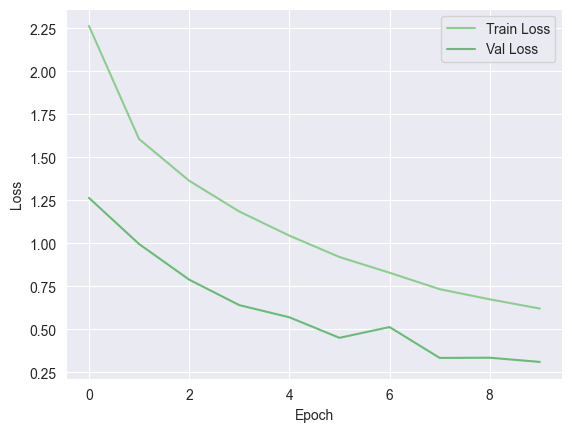

In [16]:
plot_loss(train_losses_no_cbam, val_losses_no_cbam)

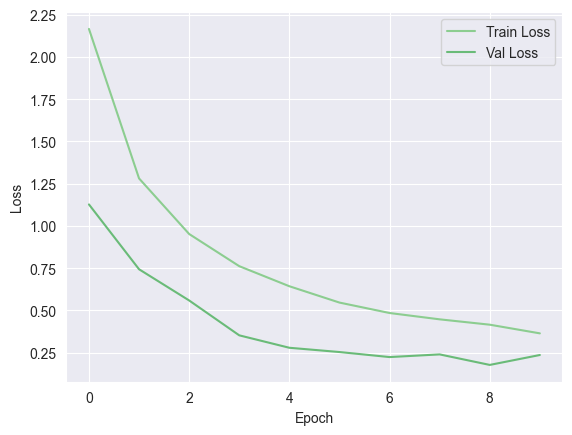

In [17]:
plot_loss(train_losses_with_cbam, val_losses_with_cbam)

In [ ]:
def evaluate_model(model, test_loader, dataset):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_labels_class_labels = [dataset.classes[i] for i in all_labels]

    return {
        "y_pred": all_preds,
        "y_true": all_labels,
        "y_true_class_labels": all_labels_class_labels,
        "f1_unaveraged": f1_score(all_labels, all_preds, average=None),
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "weighted_f1": f1_score(all_labels, all_preds, average="weighted"),
        "micro_f1": f1_score(all_labels, all_preds, average="micro"),
        "balanced_accuracy": balanced_accuracy_score(all_labels, all_preds),
        "confusion_matrix": confusion_matrix(all_labels, all_preds, normalize="true"),
        "classification_report": classification_report(all_labels, all_preds, target_names=cleaned_classes)
    }


In [32]:
resnet_no_cbam_test = PlantDiseaseMulticlassResNetOptionalCBAM(38, False).to(device)
resnet_no_cbam_test.load_state_dict(
    torch.load("resnet_no_cbam_best.pth", map_location=device)
)

resnet_cbam_test = PlantDiseaseMulticlassResNetOptionalCBAM(38, True).to(device)
resnet_cbam_test.load_state_dict(
    torch.load("resnet_with_cbam_best.pth", map_location=device)
)

resnet_no_cbam_test.eval()
resnet_cbam_test.eval()

PlantDiseaseMulticlassResNetOptionalCBAM(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): ResNetBlockCBAM(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cbam): Identity()
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResNetBlockCBAM(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  

In [38]:
resnet_no_cbam_results = evaluate_model(resnet_no_cbam_test, test_loader, dataset)
resnet_cbam_results = evaluate_model(resnet_cbam_test, test_loader, dataset)

In [39]:
for model_name, results in zip(["resnet_no_cbam", "resnet_with_cbam"], [resnet_no_cbam_results, resnet_cbam_results]):
    print(f"Classification Report for {model_name}:")
    print(results["classification_report"])
    print("\n")

Classification Report for resnet_no_cbam:
                                                   precision    recall  f1-score   support

                               Apple | Apple scab       0.86      0.80      0.83        94
                                Apple | Black rot       0.84      0.94      0.88        93
                         Apple | Cedar apple rust       0.95      1.00      0.98        41
                                  Apple | healthy       0.91      0.93      0.92       246
                              Blueberry | healthy       0.94      0.97      0.95       226
          Cherry(including sour) | Powdery mildew       0.94      0.96      0.95       158
                 Cherry(including sour) | healthy       0.78      0.99      0.87       128
Corn(maize) | Cercospora leaf spot Gray leaf spot       0.79      0.88      0.83        77
                       Corn(maize) | Common rust        1.00      0.97      0.99       179
               Corn(maize) | Northern Leaf Blig

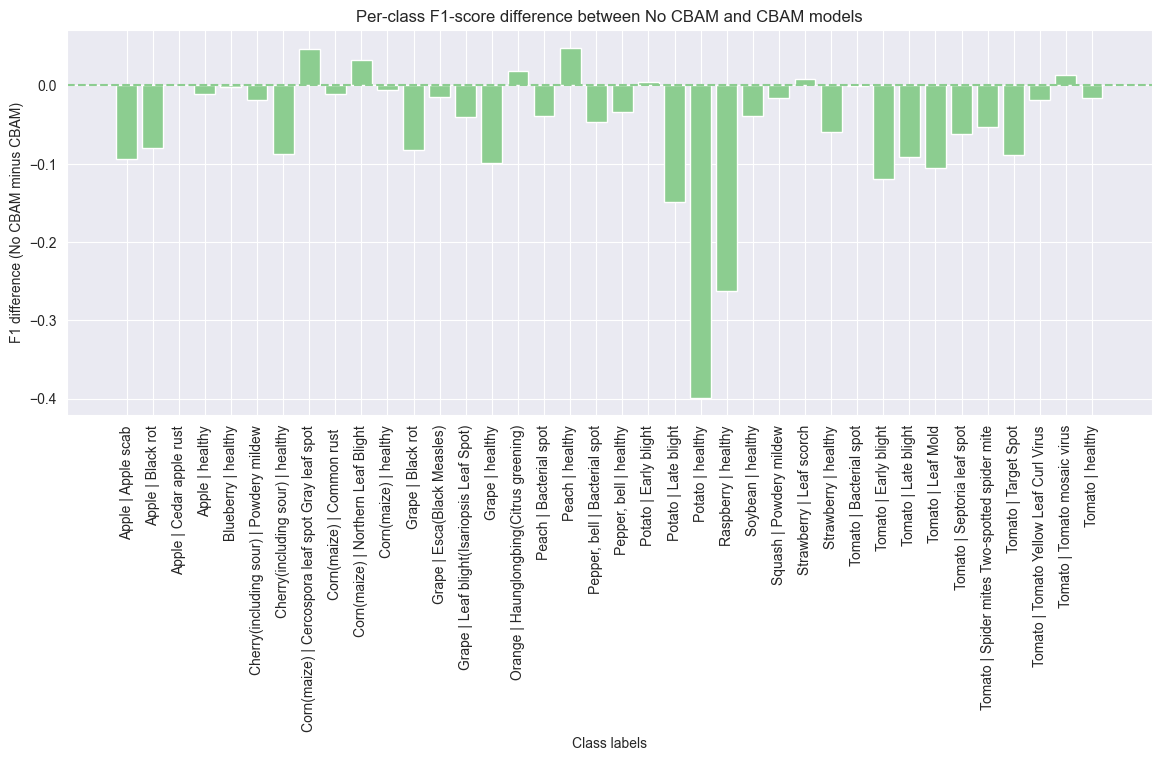

In [41]:
# F1-difference

f1_diff = resnet_no_cbam_results["f1_unaveraged"] - resnet_cbam_results["f1_unaveraged"]

plt.figure(figsize=(14, 5))
plt.bar(cleaned_classes, f1_diff)
plt.axhline(0, linestyle="--")
plt.xlabel("Class labels")
plt.xticks(rotation=90)
plt.ylabel("F1 difference (No CBAM minus CBAM)")
plt.title("Per-class F1-score difference between No CBAM and CBAM models")
plt.show()

## References
<a id="cbam">[1]</a>
Woo, Sanghyun, et al. 
"Cbam: Convolutional block attention module." 
Proceedings of the European conference on computer vision (ECCV). 2018.

<a id="plantvillage">[2]</a>
Mohanty, Sharada P., David P. Hughes, and Marcel Salathé. 
"Using deep learning for image-based plant disease detection." 
Frontiers in plant science 7 (2016): 215232.